In [1]:
from __future__ import division
import AudioLoad
import AudioFeatures
import AudioActDet
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time
import pandas as pd
%matplotlib inline

# Load Sound Track

In [2]:
reload(AudioLoad)

<module 'AudioLoad' from 'AudioLoad.pyc'>

In [3]:
AudioClass = AudioLoad.AudioLoad(Anal_Date = 'Apr-28-2017', Anal_Sample_Time=['1800Z'])

Analyzed File Type and Date: KJFK-Twr-Apr-28-2017
Duration of the sample audio: 1904.01
Sampling rate of the sample audio: 22050


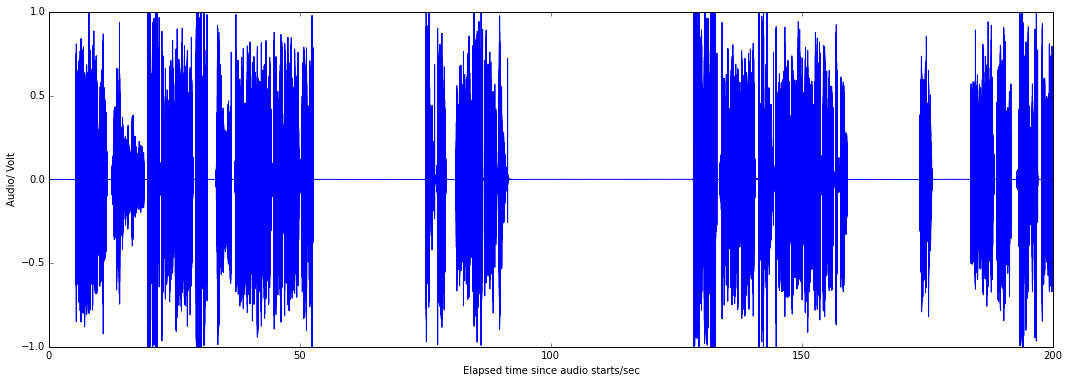

In [4]:
AudioClass.Visualizer(tmin = 0, tmax = 200)

# Feature Extraction

In [5]:
reload(AudioFeatures)

<module 'AudioFeatures' from 'AudioFeatures.pyc'>

In [6]:
FeatureClass = AudioFeatures.AudioFeatures(AudioLoad = AudioClass,
                                           nperseg = 512,
                                           overlap_rate = 8, 
                                           nfft = 1024, 
                                           fbank_hfreq = None,
                                           pre_emphasis = True)

In [7]:
features = FeatureClass.FeatureExtraction(highest_order = 2, 
                                          num_cep = 12, 
                                          lifting = True, 
                                          lifting_coef = 22, 
                                          mean_normalization = True, 
                                          nshift = 2)

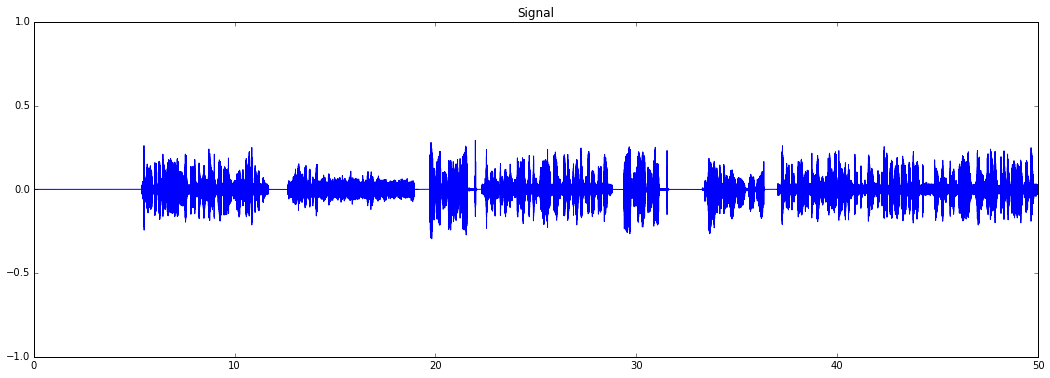

In [8]:
FeatureClass.Visualizer(item = 'signal', tmin = 0, tmax = 50)

E:\Anaconda\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


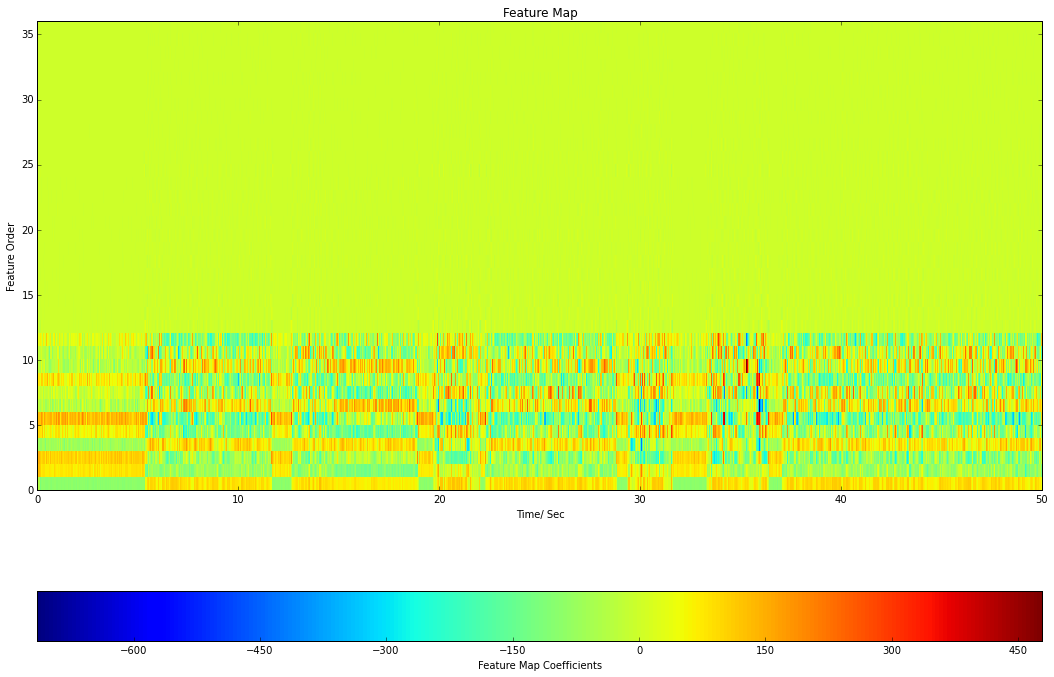

In [9]:
FeatureClass.Visualizer(item = 'features', tmin = 0, tmax = 50)

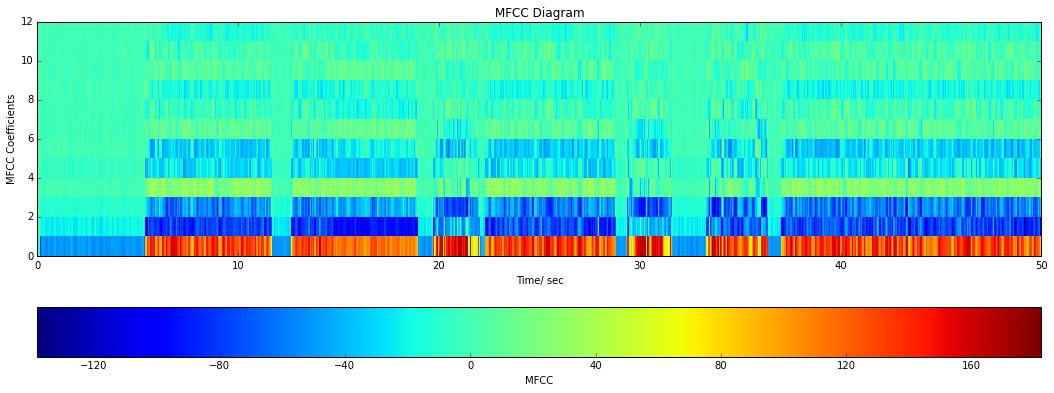

In [10]:
FeatureClass.Visualizer(item = 'mfcc', tmin = 0, tmax = 50)

AudioFeatures.py:192: RuntimeWarning: divide by zero encountered in log10
  im = plt.imshow(np.flipud(10 * np.log10(self.Pxx[:, np.where((self.time_ins >= tmin) & (self.time_ins <= tmax))[0]])),


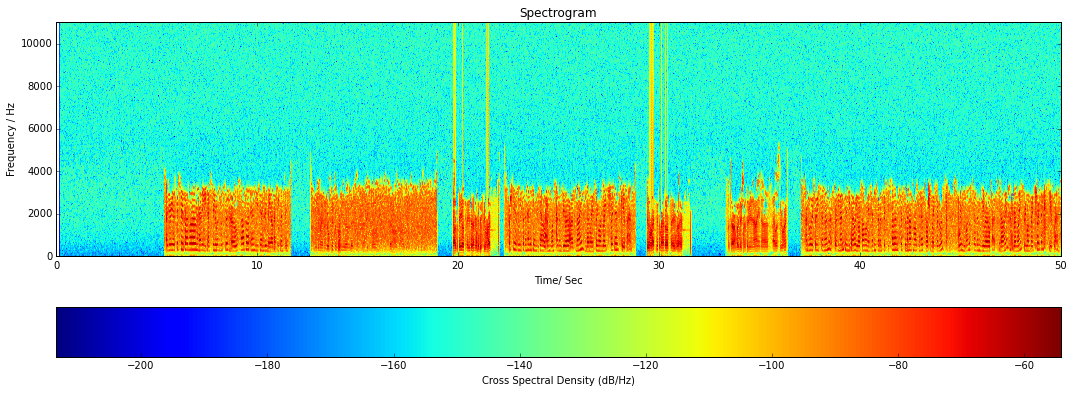

In [11]:
FeatureClass.Visualizer(item = 'spectrogram', tmin = 0, tmax = 50)

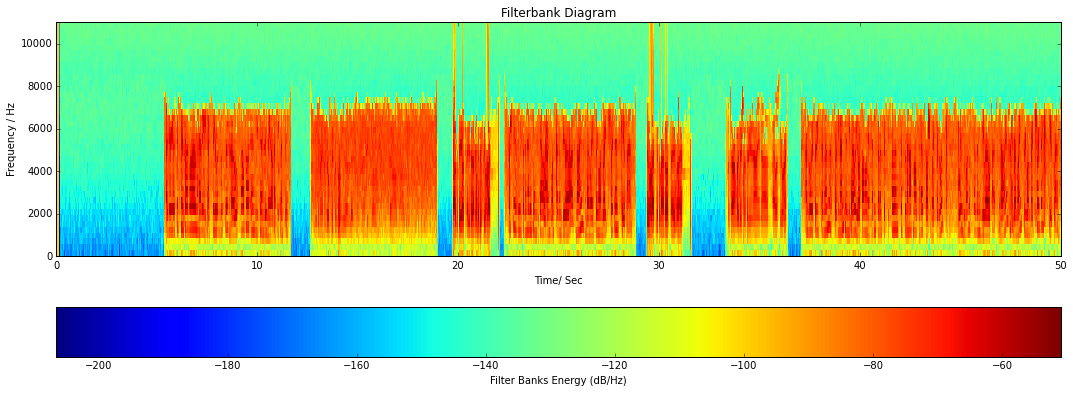

In [12]:
FeatureClass.Visualizer(item = 'filterbank', tmin = 0, tmax = 50)

# VAD

In [72]:
reload(AudioActDet)

<module 'AudioActDet' from 'AudioActDet.pyc'>

In [73]:
VADClass = AudioActDet.AudioActDet(FeatureClass)

In [74]:
sil_seg, silence_seg_2d, idx_act = VADClass.detect_silence(power_threshold = 0,
                                             silence_sec = 0.5, 
                                             mvg_point = 5)

# Audio Segmentation

In [17]:
import AudioSegmentation

In [63]:
reload(AudioSegmentation)

<module 'AudioSegmentation' from 'AudioSegmentation.py'>

In [64]:
SegClass = AudioSegmentation.AudioSegmentation(features[:, idx_act],
                                               VAD_removal = True)

In [76]:
st = time.time()
segments = SegClass.Segmentation(min_wind = 200,
                                     inc_wind = 50,
                                     max_wind = 500,
                                     mov_frame = 10,
                                     mixture = False,
                                     Lambda = 0.5)
SegIdx2d = SegClass.getResult(AudioActDet = VADClass, minDuration_sec = 0.01)
print(time.time() - st)

4.58999991417


In [77]:
gt = pd.read_csv(os.getcwd() + "/GTResults.csv")
FAR, MDR, PRC, RCL, F, missed_id = SegClass.evalResult(gt)
print(FAR)
print(MDR)
print(PRC)
print(RCL)
print(F)

0.826543209877
0.0
0.173456790123
1.0
0.295633876907


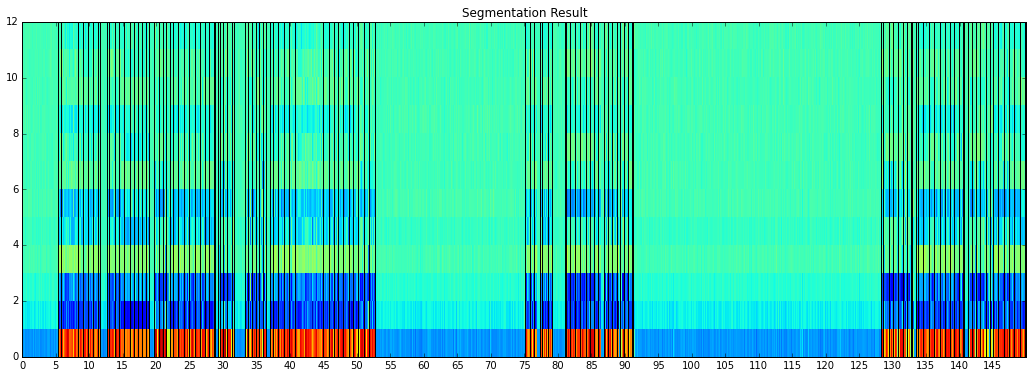

In [78]:
segTime, deadTime = SegClass.Visualizer(tmin = 0, 
                                        tmax = 150, 
                                        AudioFeatures = FeatureClass, 
                                        AudioActDet = VADClass, 
                                        xticks_gap = 5, 
                                        final = True)

In [75]:
pickle.dump(SegClass, open(os.getcwd() + '/AudioDiarization/SegClass.pkl', 'wb'), protocol=2)
pickle.dump(VADClass, open(os.getcwd() + '/AudioDiarization/VADClass.pkl', 'wb'), protocol=2)
pickle.dump(FeatureClass, open(os.getcwd() + '/AudioDiarization/FeatureClass.pkl', 'wb'), protocol=2)
pickle.dump(AudioClass, open(os.getcwd() + '/AudioDiarization/AudioClass.pkl', 'wb'), protocol=2)

# Analize from the previous run

In [2]:
SegClass = pickle.load(open(os.getcwd() + '/AudioDiarization/SegClass.pkl', 'rb'))
VADClass = pickle.load(open(os.getcwd() + '/AudioDiarization/VADClass.pkl', 'rb'))
FeatureClass = pickle.load(open(os.getcwd() + '/AudioDiarization/FeatureClass.pkl', 'rb'))
AudioClass = pickle.load(open(os.getcwd() + '/AudioDiarization/AudioClass.pkl', 'rb'))

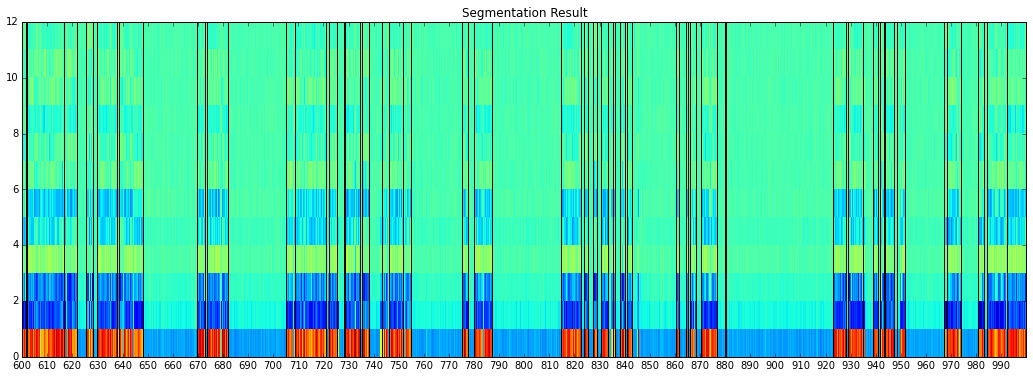

In [7]:
segTime, deadTime = SegClass.Visualizer(tmin = 600, 
                                        tmax = 1000, 
                                        AudioFeatures = FeatureClass, 
                                        AudioActDet = VADClass, 
                                        xticks_gap = 10, 
                                        final = True)

# Audio Clustering

In [38]:
import AudioCluster

In [103]:
reload(AudioCluster)

<module 'AudioCluster' from 'AudioCluster.py'>

In [104]:
AudioClusterClass = AudioCluster.AudioCluster(SegIdx2d, features)

In [105]:
pd = AudioClusterClass.getPairwiseDist()

In [106]:
pd

array([[    0.        ,  1860.52172788,  2306.29037558, ...,
         1089.0752625 ,  1184.11854433,  2141.19751646],
       [ 1860.52172788,     0.        ,  3177.55003112, ...,
         1435.54189564,  1653.18773295,  2726.81652171],
       [ 2306.29037558,  3177.55003112,     0.        , ...,
         1168.79190651,  1282.48595478,  1228.17025159],
       ..., 
       [ 1089.0752625 ,  1435.54189564,  1168.79190651, ...,
            0.        ,  1012.87652176,   960.49269746],
       [ 1184.11854433,  1653.18773295,  1282.48595478, ...,
         1012.87652176,     0.        ,  1346.73073694],
       [ 2141.19751646,  2726.81652171,  1228.17025159, ...,
          960.49269746,  1346.73073694,     0.        ]])

In [67]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN

In [101]:
testClusterDB = DBSCAN(eps = 700, min_samples = 2, metric = 'precomputed')
testClusterDB.fit(np.sqrt(pd**2))
testClusterDB.labels_ 

array([-1, -1, -1,  0, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1,  0, -1,  1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,
       -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1,  2, -1, -1,  1,  3, -1, -1,  3, -1, -1,
        1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  3, -1, -1, -1, -1, -1,
       -1, -1, -1, -1,  3, -1, -1,  3, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  1,  3, -1, -1, -1, -1, -1, -1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,
        3, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  2, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  3, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1,  3, -1, -1, -1, -1, -1, -1,  1,
       -1, -1], dtype=int

In [64]:
testCluster = AgglomerativeClustering(n_clusters = 100, affinity = 'precomputed', linkage='average')

In [65]:
testCluster.fit(pd)

AgglomerativeClustering(affinity='precomputed', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=100,
            pooling_func=<function mean at 0x0000000002501128>)

In [66]:
testCluster.labels_

array([ 4,  0,  0,  0,  0,  0,  0, 90, 85,  0,  0,  0,  0,  0,  0,  9,  0,
       55,  0,  0,  0,  0, 77,  0, 81, 52,  0, 84,  8,  0, 17, 59, 94,  0,
        0, 57, 20, 22,  0, 62,  0, 17,  4, 50, 61, 60,  0, 80, 58,  0,  0,
        0, 56,  0,  0,  0,  0, 11, 28, 73, 51, 89,  0,  0,  5,  0, 87,  0,
       72, 79, 22, 86,  3, 76, 92,  0, 69,  0, 71, 10,  0,  0,  0,  0,  8,
        0,  0, 75,  3, 27, 29, 67, 37, 65, 95, 91, 30, 63, 78,  0, 39,  7,
       66,  0,  0, 93,  5,  0,  0, 97,  0, 20, 54,  0,  0, 64,  0, 13,  7,
        0, 31, 83,  0,  0,  0,  0,  0,  0,  0, 41, 98,  0,  2, 35,  0, 32,
        0, 25,  0,  0,  0,  0, 99, 24,  0,  0,  9,  0,  0,  0, 88,  0, 96,
       42,  0,  0, 14,  0,  0,  0, 82, 49,  0,  0, 10, 70, 53, 47,  0, 74,
       11,  0,  0, 38, 40,  0,  0,  0, 45, 68,  6,  1, 26,  0, 24,  0, 36,
        0,  0, 12, 15, 44,  0,  0,  0,  0,  0, 34, 43, 21, 48,  1,  0,  0,
       46, 19,  0,  0,  0,  0,  0,  0,  0, 33,  0, 18,  0,  0,  2,  0, 23,
       16,  0], dtype=int

In [3]:
# SegClass = pickle.load(open(os.getcwd() + '/AudioDiarization/SegClass.pkl', 'rb'))
# VADClass = pickle.load(open(os.getcwd() + '/AudioDiarization/VADClass.pkl', 'rb'))
# FeatureClass = pickle.load(open(os.getcwd() + '/AudioDiarization/FeatureClass.pkl', 'rb'))
# AudioClass = pickle.load(open(os.getcwd() + '/AudioDiarization/AudioClass.pkl', 'rb'))